<h1 align="center">Deepfake detection</h1>

We are trying to detect deepfake videos. Here we are using a dataset from Kaggle where the annotations are stored in a json file in the train 
sample videos folder.

Steps:
* Reading the videos and taking images from it
* Reading the label in the json file and store the image in a folder according to it's label
* Converting the image to an array and splitting the data into train and test
* Customizing the InceptionResNetV2 and training the data on it
* Testing


## Importing necessary Libraries

In [1]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from tensorflow.keras.models import load_model

## Using the dlib face detecter to convert video to face img

In [2]:
train_frame_folder = 'train_sample_videos'

#loading the data from json file
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
    
# Saving the names of videos in a list

list_of_train_data = []

for f in os.listdir(train_frame_folder):
    if f.endswith('.mp4'):
        list_of_train_data.append(f)

detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                # Resizing the cropped image and saving it to dataset folder in png format
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (224, 224)))
                count+=1

## Converting image data to numpy array 

In [3]:
input_shape = (224, 224, 3)
data_dir = 'dataset'


#Storing the real and fake image names in lists
real_data = []
fake_data = []

for f in os.listdir(data_dir+'/real'):
    if f.endswith('.png'):
        real_data.append(f)
    
for f in os.listdir(data_dir+'/fake'):
    if f.endswith('.png'):
        fake_data.append(f)    

#Creating an empty array to store the real and fake image data
X = []

#Creating an empty array store the labels
Y = []


#Appending Numpy array info of image to X and label info to Y (1 for real and 0 for fake)
for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 224, 224, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.25, random_state=5)


# Model Building

##### We are using the Inception ResNetV2 model and customizing it

In [4]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


# Training the Model on Training Data

In [5]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 40
BATCH_SIZE = 25
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/40
110/110 [==============================] - 336s 3s/step - loss: 0.5704 - accuracy: 0.8082 - val_loss: 0.4815 - val_accuracy: 0.7930
Epoch 2/40
110/110 [==============================] - 325s 3s/step - loss: 0.3771 - accuracy: 0.8642 - val_loss: 0.4422 - val_accuracy: 0.8149
Epoch 3/40
110/110 [==============================] - 325s 3s/step - loss: 0.2240 - accuracy: 0.9376 - val_loss: 0.3248 - val_accuracy: 0.8719
Epoch 4/40
110/110 [==============================] - 325s 3s/step - loss: 0.1082 - accuracy: 0.9808 - val_loss: 0.3399 - val_accuracy: 0.8905
Epoch 5/40
110/110 [==============================] - 325s 3s/step - loss: 0.0560 - accuracy: 0.9916 - val_loss: 0.3415 - val_accuracy: 0.8970
Epoch 6/40
110/110 [==============================] - 325s 3s/step - loss: 0.0392 - accuracy: 0.9919 - val_loss: 0.3247 - val_accuracy: 0.9047
Epoch 7/40
110/110 [==============================] - 325s 3s/step - loss: 0.0209 - accuracy: 0.9976 - val_loss: 0.2948 - val_accuracy: 0.9124

# Plotting the Metrics

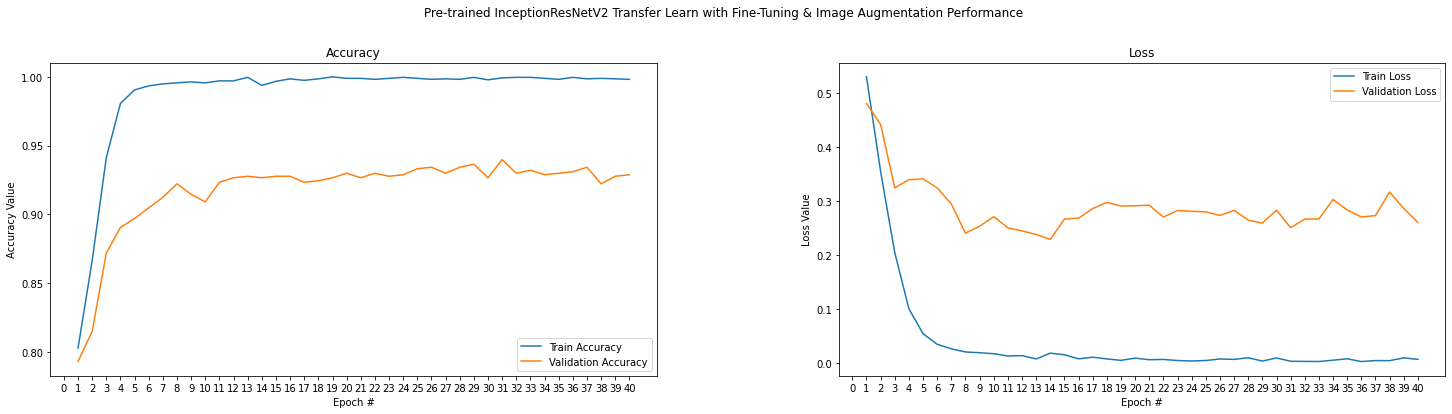

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Function to print Confusion Matrix

True positive =  2880
False positive =  42
False negative =  39
True negative =  690




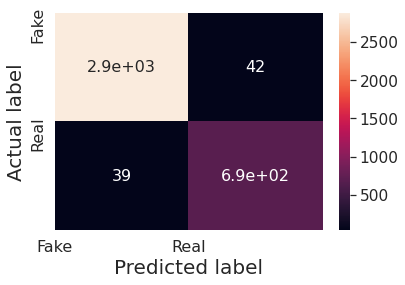

In [7]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, np.argmax(model.predict(X),axis=-1))

## Further metrics

In [8]:
f1 = f1_score(Y_val_org, np.argmax(model.predict(X),axis=-1))
cr = classification_report(Y_val_org, np.argmax(model.predict(X),axis = -1))
print(f'f1 score : {f1} \n')
print(f'Classification report : \n{cr}')

f1 score : 0.944558521560575 

Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2922
           1       0.94      0.95      0.94       729

    accuracy                           0.98      3651
   macro avg       0.96      0.97      0.97      3651
weighted avg       0.98      0.98      0.98      3651



# Saving the Model for future use

In [9]:
model.save('deepfake-detection-model.h5')

# Loading the Saved Model

In [10]:
model = load_model('deepfake-detection-model.h5')

# Testing on the sample videos

In [17]:
test_frame_folder = 'test_videos'
list_of_test_data = [f for f in os.listdir(test_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
with open(os.path.join(test_frame_folder, 'metadata.json'), 'r') as file:
    data_test = json.load(file)
    
actual_value = []
predicted_value = []
    
print('Video_name\tPredicted Actual')
print('-------------------------------')
    
for vid in list_of_test_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(test_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                data = img_to_array(cv2.resize(crop_img, (224, 224))).flatten() / 255.0
                data = data.reshape(-1, 224, 224, 3)
    actual = data_test[vid]['label']
    predicted = 'FAKE' if np.argmax(model.predict(data),axis=-1) ==[0] else 'REAL'
    print("{vid} :   {predicted}   {actual} ".format(vid = vid,predicted = predicted,actual=actual))
    
   # Storing the predictions in an array
    if np.argmax(model.predict(data),axis=-1) ==[0]:
        predicted_value.append(0)
    elif np.argmax(model.predict(data),axis=-1) ==[1]:
        predicted_value.append(1)
        
    # The label in the json file is a string so in order to get the metrics wee need to convert them to arrays
    if actual == 'FAKE':
        actual_value.append(0)
    elif actual == 'REAL':
        actual_value.append(1)

Video_name	Predicted Actual
-------------------------------
ahqqqilsxt.mp4 :   REAL   REAL 
ajwpjhrbcv.mp4 :   FAKE   FAKE 
aapnvogymq.mp4 :   FAKE   FAKE 
ajqslcypsw.mp4 :   REAL   REAL 
aipfdnwpoo.mp4 :   FAKE   FAKE 
abqwwspghj.mp4 :   FAKE   FAKE 
abofeumbvv.mp4 :   FAKE   FAKE 
aklqzsddfl.mp4 :   FAKE   FAKE 
aagfhgtpmv.mp4 :   FAKE   FAKE 
abarnvbtwb.mp4 :   REAL   REAL 


### Metrics on test data

In [12]:
predicted_value = np.array(predicted_value)  
actual_value = np.array(actual_value)

In [13]:
f1 = f1_score(actual_value,predicted_value)
print(f'f1 score : {f1} \n')

f1 score : 1.0 



True positive =  7
False positive =  0
False negative =  0
True negative =  3




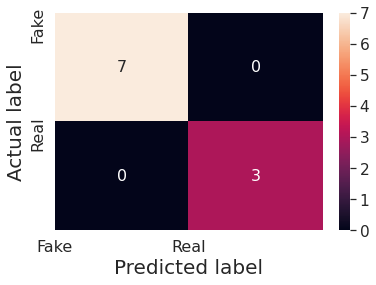

In [14]:
print_confusion_matrix(actual_value,predicted_value)

In [15]:
cr = classification_report(actual_value,predicted_value)
print(f'Classification report : \n{cr}')

Classification report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

